In [92]:
import torch, torch.nn as nn
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import snntorch.functional as SF
from snntorch import surrogate
import tonic
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D    


from tonic import datasets, transforms

torch.autograd.set_detect_anomaly(True)

dt = 30000 # -> binning every 30ms
# ^^decrease this to increase temporal resolution (possible performance boost)

# encoding_dim = 100

transform = transforms.Compose(
            [
                # transforms.Downsample(spatial_factor=encoding_dim/700),
                transforms.CropTime(max=1e6), # all timestamp units in microseconds in Tonic -> 0.8s-1.2s samples in SHD -> crops to 1s
                transforms.ToFrame(
                    sensor_size=tonic.datasets.SHD.sensor_size,
                    time_window=dt, # -> 1s/30ms = 34 frames max
                    include_incomplete=True, # if not evenly divisible by dt, include the last incomplete frame
                ),
            ]
        )

trainset=datasets.SHD('data', transform=transform)
testset=datasets.SHD('data', transform=transform, train=False)

In [17]:
trainset.__dict__

{'location_on_system': 'data/SHD',
 'transform': Compose(
     CropTime(min=0, max=1000000.0)
     ToFrame(sensor_size=(700, 1, 1), time_window=30000, event_count=None, n_time_bins=None, n_event_bins=None, overlap=0, include_incomplete=True)
 ),
 'target_transform': None,
 'transforms': None,
 'data': [],
 'targets': [],
 'folder_name': '',
 'url': 'https://zenkelab.org/datasets/shd_train.h5.zip',
 'filename': 'shd_train.h5.zip',
 'file_md5': 'f3252aeb598ac776c1b526422d90eecb',
 'data_filename': 'shd_train.h5',
 'classes': array([b'zero', b'one', b'two', b'three', b'four', b'five', b'six',
        b'seven', b'eight', b'nine', b'null', b'eins', b'zwei', b'drei',
        b'vier', b'fuenf', b'sechs', b'sieben', b'acht', b'neun'],
       dtype='|S6'),
 '_speaker': array([ 2, 11,  0, ...,  0,  9,  6], dtype=uint16)}

In [18]:
dir(trainset)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 '_folder_contains_at_least_n_files_of_type',
 '_is_file_present',
 '_speaker',
 'base_url',
 'classes',
 'data',
 'data_filename',
 'download',
 'dtype',
 'file_md5',
 'filename',
 'folder_name',
 'location_on_system',
 'ordering',
 'sensor_size',
 'speaker',
 'target_transform',
 'targets',
 'test_md5',
 'test_zip',
 'train_md5',
 'train_zip',
 'transform',
 'transforms',
 'url']

(27, 1, 700) 16
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0
  1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 2 1 0 0 0 1 0 1 1 1 0 2
  2 2 2 1 0 1 2 1 0 0 1 0 1 2 0 0 1 1 1 1 2 0 1 1 0 1 1 1 0 0 0 2 2 1 1 1
  1 1 2 2 1 0 2 0 2 2 0 1 1 1 1 3 2 1 4 1 2 3 1 1 2 3 4 3 1 1 1 2 3 1 2 1
  2 1 2 1 2 1 3 4 3 3 1 0 3 2 2 3 4 2 3 3 3 0 4 3 3 3 1 1 1 3 1 2 2 2 3 3
  1 2 4 2 3 1 0 3 2 3 1 3 6 2 1 1 0 2 2 1 4 1 1 3 2 2 3 1 3 1 0 0 1 2 2 1
  1 1 3 0 0 1 2 0 1 0 1 1 2 2 1 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 2 0 1 1 0 0
  2 2 2 2 0 2 2 2 0 1 1 3 0 1 0 2 2 3 0 0 1 2 2 0 1 2 1 0 1 2 3 2 2 0 2 0
  3 0 4 1 1 0 2 2 0 1 2 1 0 2 1 0 2 1 1 0 1 0 2 3 2 2 1 1 1 1 3 1 2 0 2 1
  1 2 1 1 1 1 1 2 0 3 1 0 1 0 0 2 2 4 1 2 1 2 0 2 2 1 3 4 3 1 3 1 2 1 3 1
  2 1 1 2 2 1 3 3 0 1 

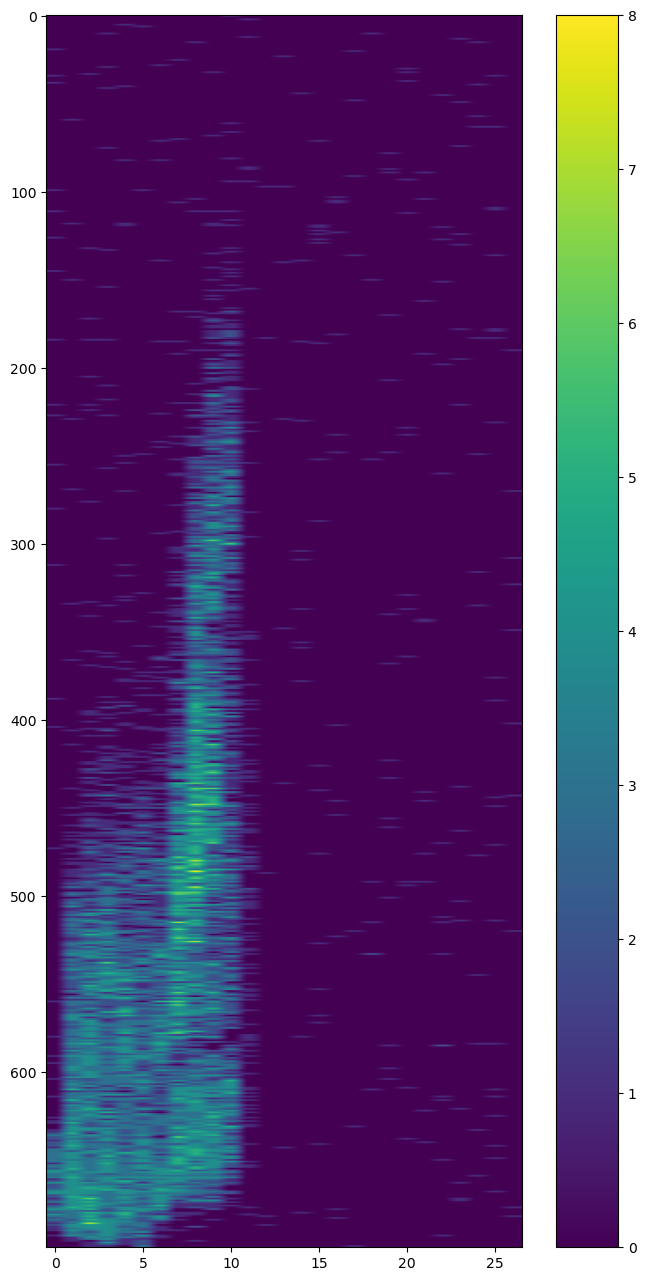

In [52]:
events, target = testset[10]
print(events.shape, target) # => shape is (27, 1, 700) -> 27 30ms events on 700 channels
print(events[10])

# plot channel x time heatmap where color represents spike count, time is 27 and channel is 700
# don't squeeze the time dimension
# since the y axis is 700 channels, make sure the plot is sized correctly -> a 16:9 aspect ratio is good
plt.figure(figsize=(9,16))

plt.imshow(events.T.squeeze())
# shrink the height increase the width of the plot
plt.gca().set_aspect(0.1, adjustable='box')

# add a colorbar
plt.colorbar()
plt.show()


(8913,) ('t', 'x', 'p') 16


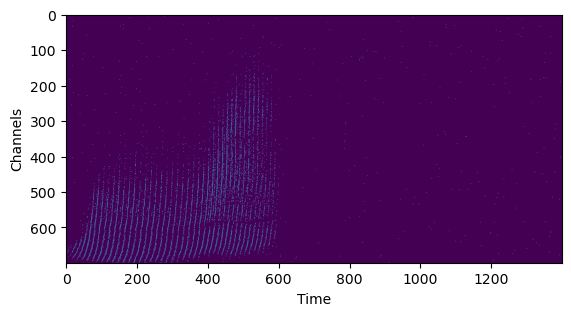

In [29]:
shd = tonic.datasets.SHD("./tutorials/data", train=False)
audio_events, label = shd[10]
print(audio_events.shape, audio_events.dtype.names, label)

tonic.utils.plot_event_grid(audio_events)

In [124]:
# !rm -r cache
from tonic import DiskCachedDataset
from torch.utils.data import DataLoader

batch_size = 64
shd_trainset = DiskCachedDataset(trainset, cache_path='./cache/shd/train')
shd_testset = DiskCachedDataset(testset, cache_path='./cache/shd/test')
train_loader = DataLoader(shd_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=False, drop_last=True)
test_loader = DataLoader(shd_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=False, drop_last=True)

In [57]:
for data, labels in iter(train_loader):
    print(data.size())
    # print(len(labels))
    

torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 32, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size([100, 34, 1, 700])
torch.Size

KeyboardInterrupt: 

In [125]:
# Training Parameters
num_classes = 20  # MNIST has 10 output classes
# device = "cuda"
device = "cpu"

# Torch Variables
dtype = torch.float

# # Torch Variables
# dtype = torch.float

# from torchvision import datasets, transforms

# # Define a transform
# transform = transforms.Compose([
#             transforms.Resize((28,28)),
#             transforms.Grayscale(),
#             transforms.ToTensor(),
#             transforms.Normalize((0,), (1,))
# ])

# mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# from torch.utils.data import DataLoader

# train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False, drop_last=True)
# test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)

In [64]:
num_steps = 28
bits = num_steps
# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

class replaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, x_r):
        return x_r

    @staticmethod
    def backward(ctx, grad):
        return (grad, grad)

# Custom Forward Grad and Traces 

In [65]:
# Custom Forward Grad and Traces 

# Network Architecture 
num_inputs = 700
num_hidden = 300
num_outputs = 20

# Temporal Dynamics
beta = 1 # no decay, IF neurons

# spike_grad = surrogate.fast_sigmoid()
spike_grad = None # -> defaults to ATan

# Define Network
class Net(nn.Module):
    def __init__(self, singleSpk=False):
        super().__init__()
        self.singleSpk = singleSpk
        if singleSpk:
            reset = "none" # -> no reset
        else:
            reset = "subtract"
        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, learn_beta=0, spike_grad=spike_grad, reset_mechanism=reset)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, learn_beta=0, spike_grad=spike_grad, reset_mechanism=reset)
            
        self.hasFired1 = torch.zeros(batch_size, num_hidden).to(device)
        self.hasFired2 = torch.zeros(batch_size, num_outputs).to(device)
        
#         self.decay = nn.parameter.Parameter(torch.ones(num_hidden))

    def clearState(self):
        self.mem1 = self.lif1.init_leaky()
        self.mem2 = self.lif2.init_leaky()
        self.hasFired1 = torch.zeros_like(self.hasFired1)
        self.hasFired2 = torch.zeros_like(self.hasFired2)
        # self.traces0 = torch.zeros(batch_size, 700).cuda()
        # self.traces1 = torch.zeros(batch_size, 300).cuda()
        self.traces0 = torch.zeros(batch_size, 700)
        self.traces1 = torch.zeros(batch_size, 300)

    def trackTrace(self, traces, spk):
        with torch.no_grad():
            traces = traces * beta + spk # -> when beta=1, this is just a running sum
        return traces


    def forward(self, x, targets, timestep=1):        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(timestep):
            spk = x[step].flatten(1)
            cur1 = self.fc1(spk)
            spk1, _ = self.lif1(cur1, self.mem1)
            if self.singleSpk:
                spk1 *= (1 - self.hasFired1)
                with torch.no_grad():
                    self.hasFired1 = torch.max(self.hasFired1, spk1)
            
#             if self.singleSpk:
#                 spk1 *= (1 - self.hasFired1)
#                 self.hasFired1 = torch.max(self.hasFired1, spk1)
            
            with torch.no_grad():
                self.traces1 = self.trackTrace(self.traces1, spk1)
                cur2 = self.fc2(spk1).detach()
            in_for_grad1 = replaceGrad.apply(spk1, self.traces1)
            out_for_grad1 = self.fc2(in_for_grad1)
            newCur2 = replaceGrad.apply(out_for_grad1, cur2)    
            spk2, self.mem2 = self.lif1(newCur2, self.mem2)
            
            
            
#             cur2 = self.fc2(spk1)
#             spk2, self.mem2 = self.lif2(cur2, self.mem2)
            
#             if self.singleSpk:
#                 spk2 *= (1 - self.hasFired2)
#                 self.hasFired2 = torch.max(self.hasFired2, spk2)

            spk2_rec.append(spk2)
            mem2_rec.append(newCur2)
#             print(cur1.shape, mem1.shape, cur2.shape, mem2.shape)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Trad SNN

In [164]:
# Net Architecture

n_inputs = events.shape[-1]
n_hidden = [300, 500]
n_outputs = len(trainset.classes)

print(n_inputs, n_hidden, n_outputs)

# Temporal Dynamics

beta = 0.9
n_steps = next(iter(train_loader))[0].shape[0]
print(n_steps)

# surrogate grad 
sg = surrogate.fast_sigmoid()

700 [300, 500] 20
34


In [165]:
# Define network 
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc_list = nn.ModuleList()
        self.lif_list = nn.ModuleList()

        fc_in = nn.Linear(n_inputs, n_hidden[0])
        self.fc_list.append(fc_in)
        lif_in = snn.Leaky(beta=beta, spike_grad=sg)
        self.lif_list.append(lif_in)

        for i in range(1, len(n_hidden)):
            fc = nn.Linear(n_hidden[i-1], n_hidden[i])
            self.fc_list.append(fc)
            lif = snn.Leaky(beta=beta, spike_grad=sg)
            self.lif_list.append(lif) 
        
        fc_out = nn.Linear(n_hidden[-1], n_outputs)
        self.fc_list.append(fc_out)
        lif_out = snn.Leaky(beta=beta, spike_grad=sg)
        self.lif_list.append(lif_out)
            
        # # Init layers
        # self.fc1 = nn.Linear(n_inputs, n_hidden)

        # self.lif1 = snn.Leaky(beta=beta, spike_grad=sg) # same as ReLU

        # self.fc2 = nn.Linear(n_hidden, n_outputs)
        # self.lif2 = snn.Leaky(beta=beta, spike_grad=sg)

    def forward(self, x):
        # Init hidden states at t=0
        # mem1 = self.lif1.init_leaky()
        # mem2 = self.lif2.init_leaky()
        mem_list = [lif.init_leaky() for lif in self.lif_list]

        # Record the final layer 
        # spk2_rec = []
        # mem2_rec = []
        spk_rec = []
        mem_rec = []

        # for step in range(n_steps):
        #     cur1 = self.fc1(x[step])
        #     spk1, mem1 = self.lif1(cur1, mem1)
            
        #     cur2 = self.fc2(spk1)
        #     spk2, mem2 = self.lif2(cur2, mem2)

        #     spk2_rec.append(spk2)
        #     mem2_rec.append(mem2)

        for step in range(n_steps):
            cur = x[step]
            for i, (fc, lif) in enumerate(zip(self.fc_list, self.lif_list)):
                cur = fc(cur)
                spk, mem = lif(cur, mem_list[i])
                mem_list[i] = mem
                cur = spk # -> pass spikes to next layer
            spk_rec.append(spk) # -> record the final layer
            mem_rec.append(mem)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

    def forward_with_rec(self, x):
            # Init hidden states at t=0
        # mem1 = self.lif1.init_leaky()
        # mem2 = self.lif2.init_leaky()
        mem_list = [lif.init_leaky() for lif in self.lif_list]

        # Record layer activity
        # spk1_rec = []
        # mem1_rec = []
        # spk2_rec = []
        # mem2_rec = []
        spk_rec = [[] for _ in range(len(self.fc_list))]
        mem_rec = [[] for _ in range(len(self.fc_list))]

        # for step in range(n_steps):
        #     cur1 = self.fc1(x[step])
        #     spk1, mem1 = self.lif1(cur1, mem1)
            
        #     cur2 = self.fc2(spk1)
        #     spk2, mem2 = self.lif2(cur2, mem2)

        #     spk1_rec.append(spk1)
        #     mem1_rec.append(mem1)
        #     spk2_rec.append(spk2)
        #     mem2_rec.append(mem2)    
        for step in range(n_steps):
            cur = fc(x[step])
            for i, (fc, lif) in enumerate(zip(self.fc_list, self.lif_list)):
                cur = fc(cur)
                spk, mem = lif(cur, mem_list[i])
                mem_list[i] = mem
                cur = spk # -> pass spikes to next layer
                spk_rec[i].append(spk)
                mem_rec[i].append(mem)
                
        # zip each recording list in spk and mem together as pairs
        rec_list = [
                [torch.stack(s_rec, dim=0), torch.stack(m_rec, dim=0)]
                for s_rec, m_rec in zip(spk_rec, mem_rec)
            ]
        
        return rec_list
    
    def visualize_all_neurons(self, x):
        # assert x.shape[0] == 1, (
        #     "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        layers_hist = self.forward_with_rec(x)
 
        for i, (layer_output, layer_state) in enumerate(layers_hist):
            layer_state, layer_output = layer_state.cpu().numpy().squeeze().transpose(), layer_output.cpu().numpy().squeeze().transpose()
 
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
 
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        # assert x.shape[0] == 1, (
        #     "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        layers_hist = self.forward_with_rec(x)
 
        # layer_state, layer_output = layers_hist[layer_idx]
        layer_state, layer_output = layers_hist[layer_idx][1].cpu().numpy().squeeze().transpose(), layers_hist[layer_idx][0].cpu().numpy().squeeze().transpose()
 
        self.plot_neuron(
            layer_state[neuron_idx], 
            title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(
            layer_output[neuron_idx], 
            title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))
 
    def plot_layer(self, layer_values, title):
        """
        This function is derived from:
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
        Which was released under the MIT License.
        """
        fig, ax = plt.subplots(figsize=(16, 4))
        im = ax.pcolormesh(layer_values, cmap='rainbow')
        plt.title(title)
        plt.colorbar(im, ax=ax)
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")

        # Set y-axis ticks to integer values
        if layer_values.shape[0] < 10:
            ticks = np.arange(0, layer_values.shape[0]+1, 1)
            ax.set_yticks(ticks)
        else:
            ticks = np.arange(0, layer_values.shape[0]+1, int(layer_values.shape[0]/10))
            ax.set_yticks(ticks)

        plt.show()
 
    def plot_neuron(self, neuron_through_time, title):
        plt.figure(figsize=(16, 4))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")

        # add the voltage threshold by accessing state_dict of the leaky neuron
        plt.axhline(y=self.lif2.threshold, color='r', linestyle='-')

        plt.show()
    


In [166]:
# Accuracy Metric via rate coding

def calc_preds(data):
    output, _ = net(data)
    # print('out', output.shape)
    # print('out sum', output.sum(dim=0).shape)
    # _, idx = output.sum(dim=0).max(1) 
    _, idx = output.sum(dim=0).squeeze().max(1)
    return output, idx

def print_batch_accuracy(data, targets, train=False, return_acc=False):
    output, idx = calc_preds(data)
    # log spike counts for each trial
    print('out spk counts', output.sum(dim=0))
    print(targets.shape, idx.shape)
    # print('class pred', idx)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
        if return_acc:
            return acc
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")
        if return_acc:
            return acc

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

def mean_max_grad(named_parameters):
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        # print(n, p.requires_grad)
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    
    return ave_grads, max_grads, layers

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads, max_grads, layers = mean_max_grad(named_parameters)

    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    # plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    # save figure with iter
    # plt.savefig(f'./trainfigs/sanity_{counter}.png')
    plt.show()
    return ave_grads, max_grads


In [172]:
net = Net()

# Loss Definition: Cross Entropy

# loss = nn.CrossEntropyLoss()

# Loss Defnition: MSE Spike Counts 

# loss = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

# Loss Definition: CE Spike Counts

loss = SF.ce_count_loss()

# Loss Definition: Max Membrane Loss 

# loss = SF.ce_max_membrane_loss()

# Loss Definition: MSE Membrane Potential

# loss = SF.mse_membrane_loss()

# Optimizer: Adam 
lr = 5e-4
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))

In [173]:
def minibatch_overfit():
    # overfit a single minibatch
    # set a loss threshold
    loss_thr = 2000
    epoch_thr = 10
    epoch_count = 0
    loss_hist = []
    # pick a random batch from train_loader
    data, targets = next(iter(train_loader))
    # data = data.permute(1, 0, 2).to(torch.float32)
    acc = 0

    print(targets)

    while acc < 1 or epoch_count < epoch_thr or loss_hist[-1] > loss_thr:
        spk_rec, mem_rec = net(data.squeeze())
        # initialize the total loss value
        # loss_val = torch.zeros((1), dtype=torch.float32, device=device)
        # for step in range(n_steps):
        #     # print(mem_rec[step], targets)
        #     loss_val += loss(mem_rec[step], targets)

        # loss_hist.append(loss_val.item())

        print(spk_rec.size(), targets.size())

        # loss_val = loss(mem_rec, targets) # mem loss
        loss_val = loss(spk_rec, targets) # spike count loss
        loss_hist.append(loss_val.item())

        print(f"Training loss: {loss_val.item():.3f}")
        acc = print_batch_accuracy(data, targets, train=True, return_acc=True)

        # clear previously stored gradients
        optimizer.zero_grad()

        # calculate the gradients
        loss_val.backward()

        # plot gradients
        grad = mean_max_grad(net.named_parameters())
        print(grad)

        # weight update
        optimizer.step()
        
        epoch_count += 1
        print(f"Epoch {epoch_count} complete")

    return loss_hist

minibatch_loss_hist = minibatch_overfit()

tensor([11, 13,  5, 10,  1, 13,  4, 14,  6,  0, 11, 17,  5,  9, 12, 12,  5,  0,
        14,  5,  9,  5, 15, 15, 19, 12,  0, 14, 19,  9,  1, 11, 12, 16,  0, 16,
        11, 15, 13, 12,  2, 14,  6, 17,  9,  3,  4,  4,  3, 11, 15,  1,  3, 12,
         1,  5,  9,  1,  6, 11, 19,  1,  7,  6])
torch.Size([34, 64, 20]) torch.Size([64])
Training loss: 3.124
out spk counts tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 1.,  ..., 0., 0., 3.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 2.]],

        [[0., 0., 2.,  ..., 0., 0., 2.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<SumBackward1>)
torch.Size([64]) torch.Size([64])
Train set accuracy for a single minibatch: 4.69%
([tensor(0.0002), tensor(0.0006), tensor(0.0042)], [tensor(0.0075), tensor(0.0174), tensor(0.5412)], ['fc_list.0.weight', 'fc_list.1.weight', 'fc_list.2.weight'])
Epoch 1 complete
torch.Size([34, 64, 20]) torch.Size([64])
Training loss: 2.969
out spk cou

In [174]:
print("Epochs on minibatch required to overfit: ", len(minibatch_loss_hist))

Epochs on minibatch required to overfit:  133


# Single Spike BPTT

In [130]:
# Single Spike BPTT

# Network Architecture
num_inputs = 700
num_hidden = 300
num_outputs = 20

# Temporal Dynamics
beta = 1

# spike_grad = surrogate.fast_sigmoid()
spike_grad = None

# Define Network
class Net(nn.Module):
    def __init__(self, singleSpk=False):
        super().__init__()
        self.singleSpk = singleSpk
        if singleSpk:
            reset = "none"
        else:
            reset = "subtract"
        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, learn_beta=0, spike_grad=spike_grad, reset_mechanism=reset)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, learn_beta=0, spike_grad=spike_grad, reset_mechanism=reset)
            
        self.hasFired1 = torch.zeros(batch_size, num_hidden).to(device)
        self.hasFired2 = torch.zeros(batch_size, num_outputs).to(device)
        
#         self.decay = nn.parameter.Parameter(torch.ones(num_hidden))
    
    def clearState(self):
        self.mem1 = self.lif1.init_leaky()
        self.mem2 = self.lif2.init_leaky()
        self.hasFired1 = torch.zeros_like(self.hasFired1)
        self.hasFired2 = torch.zeros_like(self.hasFired2)

    def forward(self, x, targets, timestep=1):        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []
        cur2_rec = []

        for step in range(timestep):
            spk = x[step].flatten(1)
            cur1 = self.fc1(spk)
            spk1, _ = self.lif1(cur1, self.mem1)
            if self.singleSpk:
                # spk1 *= (1 - self.hasFired1)
                spk1 = spk1 * (1 - self.hasFired1)
                with torch.no_grad():
                    self.hasFired1 = torch.max(self.hasFired1, spk1)
            cur2 = self.fc2(spk1)            
            spk2, self.mem2 = self.lif1(cur2, self.mem2)
            if self.singleSpk:
                # spk2 *= (1 - self.hasFired2)
                spk2 = spk2 * (1 - self.hasFired2)
                with torch.no_grad():
                    self.hasFired2 = torch.max(self.hasFired2, spk2)
            

#             cur1 = self.fc1(x[step].flatten(1))
#             spk1, self.mem1 = self.lif1(cur1, self.mem1)
            
# #             if self.singleSpk:
# #                 spk1 *= (1 - self.hasFired1)
# #                 self.hasFired1 = torch.max(self.hasFired1, spk1)
            
#             cur2 = self.fc2(spk1)
#             spk2, self.mem2 = self.lif2(cur2, self.mem2)
            
# #             if self.singleSpk:
# #                 spk2 *= (1 - self.hasFired2)
# #                 self.hasFired2 = torch.max(self.hasFired2, spk2)

            spk2_rec.append(spk2)
            mem2_rec.append(self.mem2)
            cur2_rec.append(cur2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0), torch.stack(cur2_rec, dim=0)

In [131]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target
import numpy as np

torch.manual_seed(7)
# Load the network onto CUDA if available
net = Net(singleSpk=1).to(device)
# net = Net(singleSpk=1)
   
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=17e-5, betas=(0.9, 0.999))

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=.5)

In [132]:
torch.manual_seed(7)
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0

for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.long()
        targets = targets.to(device)

        # forward pass
        net.train()
        net.clearState()
        for t in range(data.shape[0]):
            spk_rec, mem_rec, cur_rec = net(data[t:t+1], targets)
            loss_val = loss(cur_rec[-1], targets)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
       

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

    scheduler.step()
    
    with torch.no_grad():
        net.eval()
        total = 0
        correct = 0
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.long()
            targets = targets.to(device)

            # forward pass
            net.clearState()
            test_spk, mem, _ = net(data, targets, data.shape[0])

            # calculate total accuracy
#             _, predicted = test_spk.sum(dim=0).max(1)
            temp = test_spk.sum(0)
   #         temp = bin2dec(test_spk, bits, net.phase2)
            memF = mem[-1].clone()
            memF[temp!=temp.max(1)[0][:, None]] = float('-inf')
            predicted = memF.max(-1)[1]
#             if not net.singleSpk:
#                 predicted = test_spk.sum(0).max(-1)[1]
#             _, predicted = bin2dec(test_spk, bits, net.phase2).max(1)
#             _, predicted = mem[-1].max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        print(f"Total correctly classified test set images: {correct}/{total}")
        print(f"Test Set Accuracy: {100 * correct / total:.2f}%\n")
        with open("shd2.txt", "a") as f:
            f.write(f"{epoch}: {100 * correct / total:.2f}%\n")

Total correctly classified test set images: 369/2240
Test Set Accuracy: 16.47%

Total correctly classified test set images: 350/2240
Test Set Accuracy: 15.62%

Total correctly classified test set images: 312/2240
Test Set Accuracy: 13.93%

Total correctly classified test set images: 328/2240
Test Set Accuracy: 14.64%

Total correctly classified test set images: 288/2240
Test Set Accuracy: 12.86%

Total correctly classified test set images: 251/2240
Test Set Accuracy: 11.21%

Total correctly classified test set images: 236/2240
Test Set Accuracy: 10.54%

Total correctly classified test set images: 229/2240
Test Set Accuracy: 10.22%

Total correctly classified test set images: 233/2240
Test Set Accuracy: 10.40%

Total correctly classified test set images: 239/2240
Test Set Accuracy: 10.67%



In [ ]:
spk_rec[-1].requires_grad

In [92]:
mem_rec[-1]

_SpikeTensor([])